# MLP Model Evaluation

In [1]:
import yaml, glob
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels 
import logging
from sklearn.utils import class_weight
from collections import OrderedDict
from callbacks import get_callbacks
from plotting import plot_confusion_matrix
from metrics import average_acc, ece, balanced_ece
from reliability import reliability_diagram, reliability_diagrams, compute_calibration
from seed import seed_everything

### Build model and load saved weights

In [2]:
gen_model = 'mping_070722'
model_name = 'mping_070722'

# load config file
config = f'{gen_model}_config.yml'
with open(config) as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)

# load data
df = pd.read_parquet(conf['data_path'])
    
# model config
features = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
outputs = conf['outputvars']
n_splits = conf['trainer']['n_splits']
train_size1 = conf['trainer']['train_size1'] # sets test size
train_size2 = conf['trainer']['train_size2'] # sets valid size
seed = conf['trainer']['seed']
num_hidden_layers = conf['trainer']['num_hidden_layers']
hidden_size = conf['trainer']['hidden_size']
dropout_rate = conf['trainer']['dropout_rate']
batch_size = conf['trainer']['batch_size']
ra_weight = conf['trainer']['ra_weight']
sn_weight = conf['trainer']['sn_weight']
pl_weight = conf['trainer']['pl_weight']
fzra_weight = conf['trainer']['fzra_weight']
class_weights = {0:ra_weight, 1:sn_weight, 2:pl_weight, 3:fzra_weight}
learning_rate = conf['trainer']['learning_rate']
# metrics = conf['trainer']['metrics']
activation = conf['trainer']['activation']
run_eagerly = conf['trainer']['run_eagerly']
shuffle = conf['trainer']['shuffle']
epochs = conf['trainer']['epochs']
label_smoothing = conf['trainer']['label_smoothing']

# set seed
seed_everything(seed)
    
# split and preprocess the data
df['day'] = df['datetime'].apply(lambda x: str(x).split(' ')[0])
    
splitter = GroupShuffleSplit(n_splits=n_splits, train_size=train_size1, random_state=seed)
train_idx, test_idx = list(splitter.split(df, groups=df['day']))[0]
train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]
    
splitter = GroupShuffleSplit(n_splits=n_splits, train_size=train_size2, random_state=seed)
train_idx, valid_idx = list(splitter.split(train_data, groups=train_data['day']))[0]
train_data, valid_data = train_data.iloc[train_idx], train_data.iloc[valid_idx]
    
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(train_data[features])
x_valid = scaler_x.transform(valid_data[features])
x_test = scaler_x.transform(test_data[features])
y_train = train_data[outputs].to_numpy()
y_valid = valid_data[outputs].to_numpy()
y_test = test_data[outputs].to_numpy()
    
def build_model(input_size, hidden_size, num_hidden_layers, output_size):
    model = tf.keras.models.Sequential()
        
    if activation == 'leaky':
        model.add(tf.keras.layers.Dense(input_size))
        model.add(tf.keras.layers.LeakyReLU())
        
        for i in range(num_hidden_layers):
            if num_hidden_layers == 1:
                model.add(tf.keras.layers.Dense(hidden_size))
                model.add(tf.keras.layers.LeakyReLU())
            else:
                model.add(tf.keras.layers.Dense(hidden_size))
                model.add(tf.keras.layers.LeakyReLU())
                model.add(tf.keras.layers.Dropout(dropout_rate))
    else:
        model.add(tf.keras.layers.Dense(input_size, activation=activation))
        
        for i in range(num_hidden_layers):
            if num_hidden_layers == 1:
                model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
            else:
                model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
                model.add(tf.keras.layers.Dropout(dropout_rate))
        
    model.add(tf.keras.layers.Dense(output_size, activation='softmax'))
    
    return model
    
model = build_model(len(features), hidden_size, num_hidden_layers, len(outputs))
model.build((batch_size, len(features)))
model.summary()

model.load_weights(f'/glade/work/jwillson/{model_name}_opt.h5')

# np.save("/glade/work/jwillson/modeling/mping_echo_x_train.npy", x_train)
# np.save("/glade/work/jwillson/modeling/mping_echo_y_train.npy", y_train)
# np.save("/glade/work/jwillson/modeling/mping_echo_x_valid.npy", x_valid)
# np.save("/glade/work/jwillson/modeling/mping_echo_y_valid.npy", y_valid)
# np.save("/glade/work/jwillson/modeling/mping_echo_randgauss_x_test.npy", x_test)
# np.save("/glade/work/jwillson/modeling/mping_echo_y_test.npy", y_test)
# model.save("/glade/work/jwillson/modeling/mping_echo_mlp")

2022-07-07 11:04:06.320054: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/lib64:/glade/u/apps/dav/opt/openmpi/4.1.1/intel/19.1.1/lib:/glade/u/apps/dav/opt/ucx/1.11.0/lib:/glade/u/apps/opt/intel/2020u1/compilers_and_libraries/linux/lib/intel64
2022-07-07 11:04:06.320091: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-07 11:04:06.320505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is opt

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (49987, 268)              72092     
                                                                 
 dense_1 (Dense)             (49987, 110)              29590     
                                                                 
 dropout (Dropout)           (49987, 110)              0         
                                                                 
 dense_2 (Dense)             (49987, 110)              12210     
                                                                 
 dropout_1 (Dropout)         (49987, 110)              0         
                                                                 
 dense_3 (Dense)             (49987, 110)              12210     
                                                                 
 dropout_2 (Dropout)         (49987, 110)              0

### Predict on test set using saved model

In [3]:
predictions = model.predict(x_test)

probs = np.max(predictions, 1)
preds = np.argmax(predictions, 1)
labels = np.argmax(y_test, 1)
print((preds == labels).mean())
print(average_acc(y_test, predictions))

1755/1755 [==============================] - 3s 1ms/step
0.3353454415954416
0.3452470733547937


### Confusion Matrices

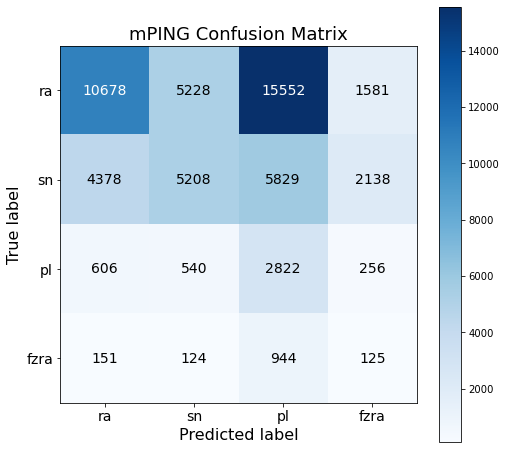

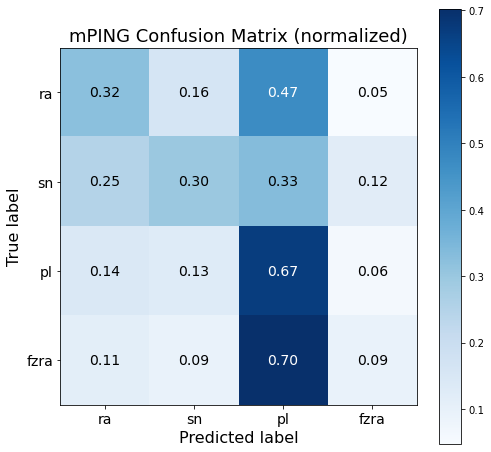

In [4]:
np.set_printoptions(precision=2)
class_names = ['ra', 'sn', 'pl', 'fzra']

# Plot non-normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names,
                      title='mPING Confusion Matrix', filename=f'{model_name}.png')

# Plot normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names, normalize=True,
                      title='mPING Confusion Matrix (normalized)', filename=f'{model_name}_norm.png')

plt.show()

### Reliability Diagrams

/glade/u/home/jwillson/winter-ptype/code/reliability.py:175: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


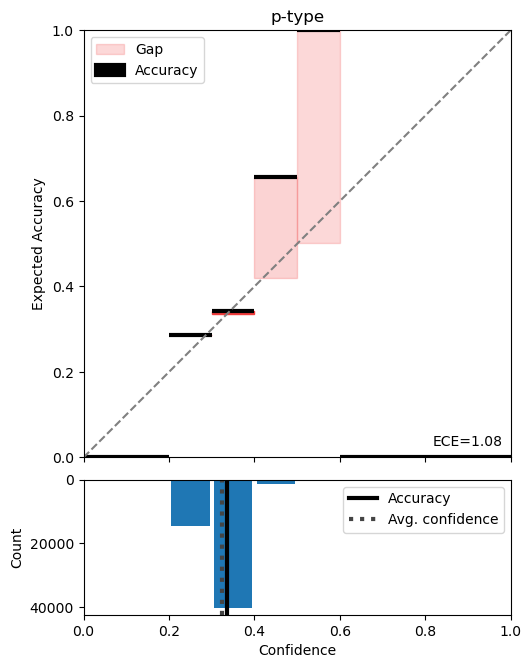

In [5]:
test_data = pd.DataFrame.from_dict(
        {"pred_labels": preds,
    "true_labels": labels, 
    "pred_conf": probs})

title = "p-type"
fig = reliability_diagram(
    test_data["true_labels"].to_numpy(),
    test_data["pred_labels"].to_numpy(),
    test_data["pred_conf"].to_numpy(),
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha", draw_averages=True,
    title=title, figsize=(5, 5), dpi=100,
    return_fig=True)

plt.savefig(conf['image_path']+f'/{model_name}_reliability.png', dpi=300, bbox_inches='tight')
plt.show()

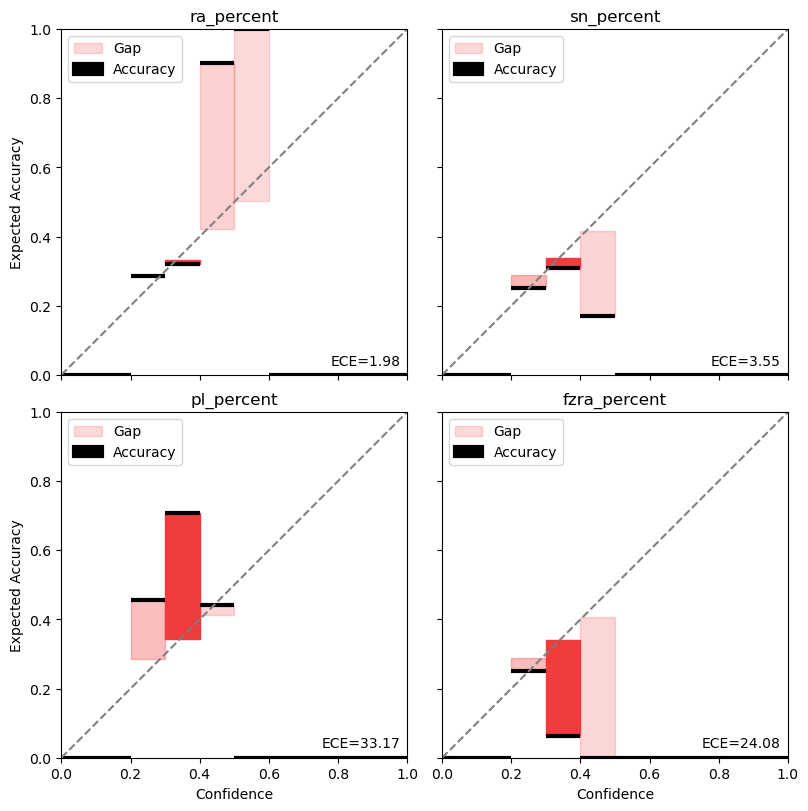

In [6]:
cond0 = (test_data["true_labels"] == 0)
cond1 = (test_data["true_labels"] == 1)
cond2 = (test_data["true_labels"] == 2)
cond3 = (test_data["true_labels"] == 3)
results = OrderedDict()
results[outputs[0]] = {
    "true_labels": test_data[cond0]["true_labels"].values,
    "pred_labels": test_data[cond0]["pred_labels"].values,
    "confidences": test_data[cond0]["pred_conf"].values
}
results[outputs[1]] = {
    "true_labels": test_data[cond1]["true_labels"].values,
    "pred_labels": test_data[cond1]["pred_labels"].values,
    "confidences": test_data[cond1]["pred_conf"].values
}
results[outputs[2]] = {
    "true_labels": test_data[cond2]["true_labels"].values,
    "pred_labels": test_data[cond2]["pred_labels"].values,
    "confidences": test_data[cond2]["pred_conf"].values
}
results[outputs[3]] = {
    "true_labels": test_data[cond3]["true_labels"].values,
    "pred_labels": test_data[cond3]["pred_labels"].values,
    "confidences": test_data[cond3]["pred_conf"].values
}
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha", num_cols=2, dpi=100, return_fig=True)
plt.savefig(conf['image_path']+f'/{model_name}_class_reliability.png', dpi=300, bbox_inches='tight')
plt.show()

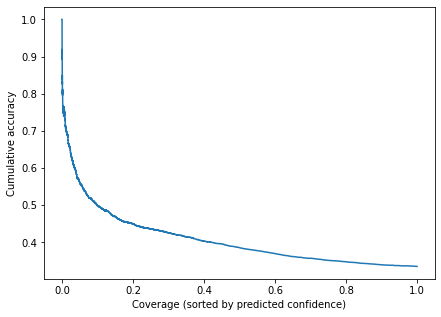

In [7]:
def compute_cov(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

test_data["acc"] = (test_data["pred_labels"] == test_data["true_labels"]).to_numpy()
test_data_sorted = compute_cov(test_data, col = "pred_conf", quan = "acc")

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(
    test_data_sorted["pred_conf_cov"],
    test_data_sorted["cu_acc"]
)
ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])

ax2 = ax.twiny()
ax2.set_xlabel("Test Data Fraction", fontsize=14)
ax2.plot(
    test_data_sorted["pred_conf_cov"],
    test_data_sorted["cu_acc"]
)
ax.set_ylabel("Cumulative Accuracy", fontsize=14)
ax.set_xlabel("Confidence", fontsize=14)

plt.savefig(conf['image_path']+f'/{model_name}_acc_vs_cov.png', dpi=300, bbox_inches='tight')
plt.show()

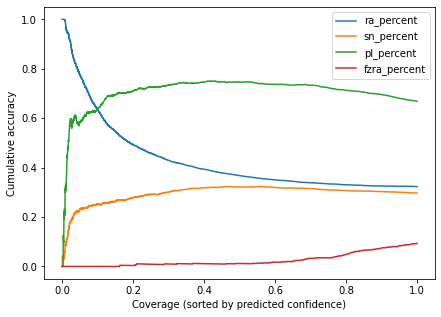

In [8]:
# fig = plt.figure(figsize=(7, 5))
# ax = fig.add_subplot(1, 1, 1)
# for c in [cond0, cond1, cond2, cond3]:
#     _test_data_sorted = compute_cov(test_data[c], col = "pred_conf", quan = "acc")
#     ax.plot(
#         _test_data_sorted["pred_conf_cov"],
#         _test_data_sorted["cu_acc"]
#     )
# ax.set_ylabel("Cumulative accuracy")
# ax.set_xlabel("Coverage (sorted by predicted confidence)")
# plt.legend(outputs)
# plt.savefig(conf['image_path']+f'/{model_name}_class_acc_vs_cov.png', dpi=300, bbox_inches='tight')
# plt.show()

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1)
ax2 = ax.twiny()
for c in [cond0, cond1, cond2, cond3]:
    _test_data_sorted = compute_cov(test_data[c], col = "pred_conf", quan = "acc")
    ax.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_acc"]
    )
    ax2.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_acc"]
    )

ax.set_xticklabels([1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0])
ax.set_ylabel("Cumulative Accuracy", fontsize=14)
ax2.set_xlabel("Test Data Fraction", fontsize=14)
ax.set_xlabel("Confidence", fontsize=14)
ax.legend(outputs)
plt.savefig(conf['image_path']+f'/{model_name}_class_acc_vs_cov.png', dpi=300, bbox_inches='tight')
plt.show()